In [1]:
import os
import random
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.transforms.functional as TF

In [2]:
RAW_DIR       = "Dataset"                      
PROC_DIR = os.path.join(RAW_DIR, "processed") 
IMG_SIZE      = (224, 224)
BATCH_SIZE    = 32
VAL_SPLIT     = 0.15
TEST_SPLIT    = 0.15
SEED          = 42

for cls in ["Levitan", "Non-levitan"]:
    os.makedirs(os.path.join(PROC_DIR, cls), exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# rename files
def rename_levitan(src_folder):
    """
    ĐỔI TÊN tất cả file → levitan_{idx:03d}.ext
    2 PHASES để tránh collision khi chạy nhiều lần.
    """
    files = sorted(f for f in os.listdir(src_folder)
                   if os.path.isfile(os.path.join(src_folder, f))
                   and not f.startswith(".temp_"))
    temp_names = []
    for i, fname in enumerate(files, 1):
        ext = os.path.splitext(fname)[1].lower()
        tmp = f".temp_levitan_{i:03d}{ext}"
        os.rename(os.path.join(src_folder, fname),
                  os.path.join(src_folder, tmp))
        temp_names.append(tmp)
    for tmp in temp_names:
        base, ext = os.path.splitext(tmp)    
        idx = base.split('_')[-1]            
        final = f"levitan_{idx}{ext}"
        os.rename(os.path.join(src_folder, tmp),
                  os.path.join(src_folder, final))


def rename_nonlevitan(src_folder):
    """
    ĐỔI TÊN tất cả file → non-levitan_{PainterName}_{idx:03d}.ext
    2 PHASES, rút gọn mọi tiền tố non-levitan hiện có, rồi đánh số lại.
    """
    files = sorted(f for f in os.listdir(src_folder)
                   if os.path.isfile(os.path.join(src_folder, f))
                   and not f.startswith(".temp_"))
    groups = {}
    for fname in files:
        base = os.path.splitext(fname)[0]
        while base.startswith("non-levitan_"):
            base = base[len("non-levitan_"):]
        painter = base.rsplit('_', 1)[0]
        groups.setdefault(painter, []).append(fname)

    temp_info = []
    for painter, flist in groups.items():
        for i, fname in enumerate(sorted(flist), 1):
            ext = os.path.splitext(fname)[1].lower()
            tmp = f".temp_{painter}_{i:03d}{ext}"
            os.rename(os.path.join(src_folder, fname),
                      os.path.join(src_folder, tmp))
            temp_info.append(tmp)

    for tmp in temp_info:
        base, ext = os.path.splitext(tmp)     
        parts = base.split('_')
        painter = "_".join(parts[1:-1])     
        idx     = parts[-1]                  
        final = f"non-levitan_{painter}_{idx}{ext}"
        os.rename(os.path.join(src_folder, tmp),
                  os.path.join(src_folder, final))


for cls, fn in [("Levitan", rename_levitan),
                ("Non-levitan", rename_nonlevitan)]:
    folder = os.path.join(RAW_DIR, cls)
    print(f"> Renaming in {folder} ...")
    fn(folder)
print("✅ Rename hoàn tất.")

> Renaming in Dataset\Levitan ...
> Renaming in Dataset\Non-levitan ...
✅ Rename hoàn tất.


In [4]:
# Resize + Geometric Augmentation 
classes       = ["Levitan", "Non-levitan"]
def geometric_augs(img):
    """
    Trả về list các (tag, PIL Image) đã augmented từ img (đã resize).
    Bao gồm:
      - orig    : ảnh gốc
      - flip    : horizontal flip
      - rot10   : rotate +10°
      - rot-10  : rotate -10°
      - crop    : center crop 80% rồi resize lại
    """
    w, h = IMG_SIZE
    return [
        ("orig",   img),
        ("flip",   TF.hflip(img)),
        ("rot10",  img.rotate(10,  resample=Image.BILINEAR)),
        ("rot-10", img.rotate(-10, resample=Image.BILINEAR)),
        ("crop",   TF.center_crop(img, (int(0.8*h), int(0.8*w)))
                    .resize(IMG_SIZE, Image.BILINEAR)),
    ]

for cls in classes:
    src_dir = os.path.join(RAW_DIR, cls)
    dst_dir = os.path.join(PROC_DIR, cls)
    for fname in tqdm(os.listdir(src_dir), desc=f"Processing {cls}"):
        src_path = os.path.join(src_dir, fname)
        if not os.path.isfile(src_path) or fname.startswith("."):
            continue

        img = Image.open(src_path).convert("RGB")
        img = img.resize(IMG_SIZE, Image.BILINEAR)

        base, ext = os.path.splitext(fname)
        for tag, aug_img in geometric_augs(img):
            out_name = f"{base}_{tag}{ext}"
            out_path = os.path.join(dst_dir, out_name)
            aug_img.save(out_path)


Processing Non-levitan: 100%|██████████| 110/110 [00:02<00:00, 37.07it/s]


In [5]:
# transform 
train_tf = transforms.Compose([
    # Photometric augmentations
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1,1.0)),
    # Tensorize + Normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# load dataset
PROC_DIR = "Dataset/processed"
full_ds  = datasets.ImageFolder(PROC_DIR, transform=train_tf)
classes  = full_ds.classes
print("Classes:", classes)

# split với rate 70/15/15 
TOTAL      = len(full_ds)
VAL_SIZE   = int(0.15 * TOTAL)
TEST_SIZE  = int(0.15 * TOTAL)
TRAIN_SIZE = TOTAL - VAL_SIZE - TEST_SIZE

train_ds, val_ds, test_ds = random_split(
    full_ds,
    [TRAIN_SIZE, VAL_SIZE, TEST_SIZE],
    generator=torch.Generator().manual_seed(42)
)

# Override transform cho val/test (không augment)
val_ds.dataset.transform  = val_tf
test_ds.dataset.transform = val_tf
print(f"Sizes → Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")


Classes: ['Levitan', 'Non-levitan']
Sizes → Train: 753, Val: 161, Test: 161
Train batches: 24, Val batches: 6, Test batches: 6


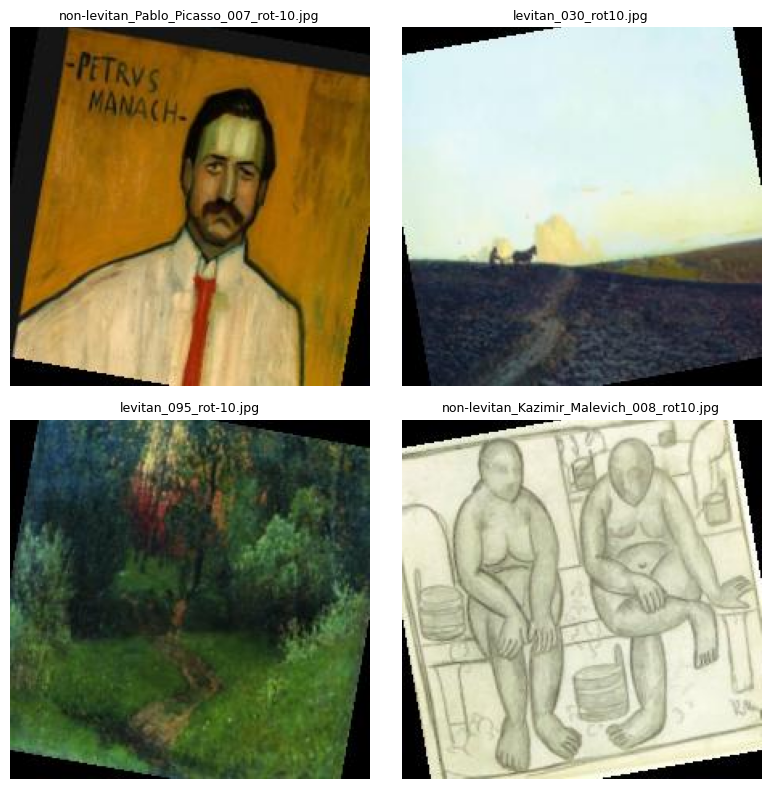

In [6]:
DATA_DIR = "Dataset/processed"
classes  = ["Levitan", "Non-levitan"]

all_paths = []
for cls in classes:
    folder = os.path.join(DATA_DIR, cls)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg','.jpeg','.png')):
            all_paths.append(os.path.join(folder, fname))

samples = random.sample(all_paths, 4)

fig, axes = plt.subplots(2, 2, figsize=(8,8))
for ax, path in zip(axes.flatten(), samples):
    img = Image.open(path)
    ax.imshow(img)
    ax.set_title(os.path.basename(path), fontsize=9)
    ax.axis("off")
plt.tight_layout()
plt.show()